# ECG Wistar
This tool is a software developed in Python for analyzing ECG data from rats. <br>
The program includes a signal preprocessing step and identification of the R peak for calculating heart rate and cardiac variability. <br>
<br>
The filtering functionalities for the signal preprocessing step include:<br>
baseline wander removal techniques <br>
frequency filtering (highpass, lowpass and Notch filter) <br>
isoline correction <br>
<br>
This article, Pilia, N., Nagel, C., Lenis, G., Becker, S., Dössel, O., Loewe, A. (2021) ECGdeli - An Open Source ECG Delineation Toolbox for MATLAB. SoftwareX 13:100639. doi:10.1016/j.softx.2020.100639, was used as a reference for the development of the tool. <br>
The project was developed in Karlsruhe Institute of Technology (KIT) by Mariana Valerio. <br>
<br>
Last update date: 

## Tool purpose

Both heart rate (HR) and heart rate variability (HRV) are currently associated with cardiovascular disease, mental disorders, and cognitive impairment. Patients with reduced or abnormal HR variability have an increased risk of mortality, especially after myocardial infarction (MI). Therefore, the proposal and development of new tools for studying HR and HRV are essential to improve the understanding of these parameters and their relationship with cardiovascular disease.<br>

The proposal and development of new tools for analyzing heart rate (HR) and heart rate variability (HRV) are essential to deepen the understanding of these parameters and their relationship with health, allowing advances in cardiovascular risk assessment and autonomic monitoring.<br>

Time-domain measurements have been widely used in risk stratification in patients with cardiovascular disease and also in the investigation of the underlying causes of these disorders. In atrial fibrillation (AF), HRV parameters tend to show random patterns due to irregular heart rhythm. However, the atria have a strong autonomic innervation, and the atrioventricular (AV) node is highly sensitive to modulation by the autonomic nervous system. Among the parameters analyzed, a pNN20 greater than 87% has been identified as a strong indicator of AF.<br>

Patients with atrial fibrillation are at high risk of serious cardiovascular events, making it crucial to develop new clinical tools to identify those at greatest risk. The study of HRV also stands out as an effective method to assess vagus nerve function, providing valuable information on autonomic balance and cardiac control (sympathetic and parasympathetic).<br>
<br>

## Import libraries

In [2]:
import matplotlib.pyplot as plt
from openpyxl import load_workbook
import numpy as np
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import PchipInterpolator
from scipy.signal import butter, sosfiltfilt, decimate, welch
import scipy.signal as signal
from scipy.signal import decimate
from scipy.signal import resample
from scipy.io import loadmat
from scipy.signal import find_peaks
from scipy.stats import scoreatpercentile
import pywt

## Defining constants
It is important that the signal has the same determined sampling.

In [3]:
lowpass_frequency = 100
highpass_frequency = 0.5
notch_frequency = 50
samplerate = 1000
window_length = 1
overlap = 0.5
width = 1

## Functions start

### ECG filter
The input signal can be either one-dimensional or two-dimensional, representing a single data channel or multiple channels. If the signal is one-dimensional, it is expanded to two dimensions for ease of processing. <br>
The filtering method is determined by an input parameter, which can specify methods such as Butterworth, Gaussian or Smooth. In this case, the Butterworth method was chosen. <br>
The core of the function is the application of filters, these filters being low-pass, high-pass, notch and band-pass filters. After the filters are applied, the signal is adjusted for baseline correction, a procedure that normalizes the signal to remove any residual DC offset.<br>

In [4]:
def ecg_filter(signal, samplerate, filter_types, lowpass_frequency=None, highpass_frequency=None, notch_frequency=None, filter_method='Butterworth'):
    if signal.ndim == 1:
        signal = signal[:, np.newaxis]
    if signal.shape[1] > signal.shape[0]:
        signal = signal.T
        transpose_flag = True
    else:
        transpose_flag = False

    if filter_method.lower() in ['smooth', 's']:
        case_var = 1
    elif filter_method.lower() in ['gauss', 'g']:
        case_var = 2
    elif filter_method.lower() in ['butterworth', 'b']:
        case_var = 3
    else:
        raise ValueError('Filter method not recognized')

    if not np.issubdtype(signal.dtype, np.float64):
        signal = signal.astype(np.float64)

    n_samples, n_channels = signal.shape
    l = int(round(samplerate * 10))
    filteredsignal = np.pad(signal, ((l, l), (0, 0)), mode='constant')

    if lowpass_frequency and lowpass_frequency > samplerate / 2:
        lowpass_frequency = samplerate / 2 - 1
    if highpass_frequency and highpass_frequency > samplerate / 2:
        highpass_frequency = samplerate / 2 - 1

    for filter_type in filter_types:
        if filter_type == 'low':
            filteredsignal = apply_lowpass_filter(filteredsignal, samplerate, lowpass_frequency, case_var, n_channels)
        elif filter_type == 'high':
            filteredsignal = apply_highpass_filter(filteredsignal, samplerate, highpass_frequency, case_var, n_channels)
        elif filter_type == 'notch':
            filteredsignal = apply_notch_filter(filteredsignal, samplerate, notch_frequency, width)
        elif filter_type == 'band':
            if lowpass_frequency is None or highpass_frequency is None:
                raise ValueError('Both lowpass_frequency and highpass_frequency must be specified for bandpass filter.')
            filteredsignal = apply_bandpass_filter(filteredsignal, samplerate, lowpass_frequency, highpass_frequency, case_var, n_channels)
        else:
            raise ValueError('Filter type not recognized')

    filteredsignal = filteredsignal[l:-l, :]
    filteredsignal, offset = isoline_correction(filteredsignal)

    if transpose_flag:
        filteredsignal = filteredsignal.T

    return filteredsignal

### Low-pass filter
This filter attenuates high-frequency components while preserving low-frequency components. <br>
The function offers three different approaches to filtering, which are selected using the case_var parameter: simple smoothing filtering, Gaussian filtering, and Butterworth filtering.
<br>
In the first method, called the smoothing filter, the filter is applied using a moving average. The second method uses a Gaussian filter. The third method is the Butterworth filter, which allows effective attenuation of frequencies outside the passband without compromising signal stability. The filter coefficients are calculated using the butter function for a specific cutoff frequency, normalized by the sampling rate. The filter is applied bidirectionally using the sosfiltfilt function, which filters the signal in both the forward and reverse directions. <br>

In [5]:
def apply_lowpass_filter(signal, samplerate, lowpass_frequency, case_var, n_channels):
    if case_var == 1:  
        nw = int(round(samplerate / lowpass_frequency))
        for i in range(n_channels):
            signal[:, i] = smooth(signal[:, i], nw)
    elif case_var == 2:  
        sigmaf = lowpass_frequency
        sigma = samplerate / (2 * np.pi * sigmaf)
        signal = gaussian_filter1d(signal, sigma, axis=0)
    elif case_var == 3:  
        order = 3
        sos = butter(order, 2 * lowpass_frequency / samplerate, btype='low', output='sos')
        for i in range(n_channels):
            signal[:, i] = sosfiltfilt(sos, signal[:, i])
            
    return signal

### High-pass filter
Removes unwanted low frequency <br>
The butter function is then used to calculate the filter coefficients, which are represented in the sos (Second-Order Sections) format.<br>

The next step involves applying the filter. This is done through a loop that loops through each channel, applying the filter using the sosfiltfilt function. This function applies the filter twice: once in the forward direction and once in the reverse direction.<br>

In [6]:
def apply_highpass_filter(signal, samplerate, highpass_frequency, case_var, n_channels):
    if case_var == 3:  
        order = 3
        sos = butter(order, 2 * highpass_frequency / samplerate, btype='high', output='sos')
        for i in range(n_channels):
            signal[:, i] = sosfiltfilt(sos, signal[:, i])
    else:
        raise NotImplementedError("High-pass filter is only implemented for Butterworth filter.")
    return signal

### Notch filter
This filter removes specific unwanted frequencies. <br>

The first step of the function is to calculate the number of harmonics of the rejection frequency that can be filtered without exceeding the Nyquist frequency (half the sampling rate). <br>

To mitigate edge effects, the function extends the signal at its ends. This extension is calculated based on the sampling rate and the width of the rejection band (width), resulting in a number of additional points (extpoints) that are added symmetrically to the beginning and end of the signal.<br>

With the signal extended, the function proceeds to the frequency domain, where it constructs a frequency vector f through the Fourier transform. The width of the rejection filter is then adjusted using a Gaussian bell. The Gaussian bell is inverted and scaled so that the maximum value is 1 and the minimum is 0, allowing a smooth transition when applying the filter.<br>

In the frequency domain, the extended signal is transformed using the Fourier transform, and the H filter is applied by multiplying the frequency coefficients. Multiplying H with the signal transform selectively removes the unwanted frequencies. The signal is then converted back to the time domain using the inverse Fourier transform.<br>

Finally, the function removes the extended portions of the signal, returning it to its original duration.<br>

In [7]:
def apply_notch_filter(signal, samplerate, notch_frequency, width):
    K = int(np.floor(samplerate / 2 / notch_frequency))

    extpoints = int(round(0.5 * np.ceil(samplerate / width)))
    signal_extended = np.pad(signal, ((extpoints, extpoints), (0, 0)), 'symmetric')

    L = signal_extended.shape[0]  
    f = np.fft.fftfreq(L, d=1 / samplerate)  

    sigmaf = width  
    sigma = int(np.ceil(L * sigmaf / samplerate))  
    lg = 2 * round(4 * sigma) + 1  
    lb = (lg - 1) // 2  

    g = gaussian_filter1d(np.eye(1, lg).flatten(), sigma)
    g = 1 / (np.max(g) - np.min(g)) * (np.max(g) - g)  

    H = np.ones(L)  

    for k in range(1, K + 1):
        b = np.argmin(np.abs(f - k * notch_frequency))  
        H[b - lb:b + lb + 1] = g  
        H[L - b - lb:L - b + lb + 1] = g  

    H = np.tile(H, (signal_extended.shape[1], 1)).T  
    X = np.fft.fft(signal_extended, axis=0)  
    Y = H * X  
    signal = np.real(np.fft.ifft(Y, axis=0))  
    signal = signal[extpoints:-extpoints, :]  

    return signal

### Band-pass filter
This filter allows only a specific range of frequencies to pass, while attenuating frequencies outside that range. <br>

In [8]:
def apply_bandpass_filter(signal, samplerate, lowpass_frequency, highpass_frequency, case_var, n_channels):
    signal = apply_lowpass_filter(signal, samplerate, lowpass_frequency, case_var, n_channels)
    signal = apply_highpass_filter(signal, samplerate, highpass_frequency, case_var, n_channels)
    
    return signal

### Isoline correction
The function removes a constant offset present in the signal.<br>

Initially, the function checks whether the input signal is one-dimensional, that is, if it has only one dimension. If this is confirmed, the signal is converted into a column matrix, which ensures that subsequent processing is uniform. If the number of bins is not specified, the function sets a default value that is the minimum between 1024 and the number of samples in the signal, ensuring an adequate number of bins for creating the histogram. <br>

An offset matrix is created to store the offsets that will be calculated and subtracted from each channel of the signal. For each channel, a histogram is calculated with the previously defined number of bins. The bin that contains the largest number of occurrences is identified, and the offset value is calculated as the average of the limits of that bin. This offset is then subtracted from all samples in the corresponding channel, resulting in the removal of the constant offset. <br>

In [9]:
def isoline_correction(signal, number_bins=None):
    if signal.ndim == 1:
        signal = signal[:, np.newaxis]
    filteredsignal = np.zeros_like(signal)
    number_channels = signal.shape[1]
    if number_bins is None:
        number_bins = min(2 ** 10, signal.shape[0]) 

    frequency_matrix = np.zeros((number_bins, number_channels))
    bins_matrix = np.zeros_like(frequency_matrix)
    offset = np.zeros(number_channels)

    for i in range(number_channels):
        frequency_matrix[:, i], bin_edges = np.histogram(signal[:, i], bins=number_bins)
        pos = np.argmax(frequency_matrix[:, i])  
        offset[i] = (bin_edges[pos] + bin_edges[pos + 1]) / 2 
        filteredsignal[:, i] = signal[:, i] - offset[i]  

    return filteredsignal, offset

### Smooth
Performs signal smoothing by applying a convolution technique with a Hanning window <br>


In [10]:
def smooth(signal, window_len):
    s = np.r_[signal[window_len - 1:0:-1], signal, signal[-2:-window_len - 1:-1]]
    w = np.hanning(window_len)
    y = np.convolve(w / w.sum(), s, mode='valid')
    return y[int(window_len / 2 - 1):-int(window_len / 2)]

### Baseline removal
Removes the baseline from the signal <br>

The function proceeds to calculate an estimate of the local baseline. This is done by calculating the median of the signal values. These median points are then used to create a continuous baseline by interpolation with the PchipInterpolator function. The interpolated baseline is subtracted from the original signal to remove jitter <br>

To ensure a more accurate correction, the function applies an additional adjustment with the isoline correction function, which removes any residual offset in the filtered signal. After this correction, a small value of 0.05 is added to prevent minimal negative values from interfering with subsequent analyses <br>

In [11]:
def ecg_baseline_removal(signal, samplerate, window_length, overlap):
    L = signal.shape[0]
    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)
    NCH = signal.shape[1]

    baseline = np.zeros_like(signal)
    filtered_signal = np.zeros_like(signal)

    window_length = int(round(window_length * samplerate))
    window_length = window_length + 1 - window_length % 2
    window_half_length = (window_length - 1) // 2

    if 0 <= overlap < 1:
        N = int(np.floor((L - window_length * overlap) / (window_length * (1 - overlap))))
        center = np.round(window_length * (1 - overlap) * np.arange(N)) + window_half_length
        center = center.astype(int)
    elif overlap == 1:
        center = np.arange(1, L + 1)
        N = len(center)
    else:
        raise ValueError('overlap must be a number between 0 and 1')

    for j in range(NCH):
        baseline_points = np.zeros(center.shape)
        for i in range(N):
            leftInt = max(center[i] - window_half_length, 0)
            rightInt = min(center[i] + window_half_length, L)
            baseline_points[i] = np.median(signal[leftInt:rightInt, j])

        interpolator = PchipInterpolator(center, baseline_points)
        baseline[:, j] = interpolator(np.arange(L))
        filtered_signal[:, j] = signal[:, j] - baseline[:, j]

        corrected_signal, offset = isoline_correction(filtered_signal[:, j][:, np.newaxis])
        filtered_signal[:, j] = corrected_signal.flatten()
        baseline[:, j] += offset
        filtered_signal[:, j] += 0.05

    return filtered_signal, baseline


### Butter high-pass filter
The following two filters do not need the "case_var, n_channels" variables. Made only for Butterworth filtering <br>

In [12]:
def butter_highpass_filter(signal, samplerate, highpass_frequency):
    order = 3
    n_channels = 1
    sos = butter(order, 2 * highpass_frequency / samplerate, btype='high', output='sos')

    if n_channels == 1:
        filtered_signal3 = sosfiltfilt(sos, signal)
    else:
        filtered_signal3 = np.zeros_like(signal)
        for i in range(n_channels):
            filtered_signal3[:, i] = sosfiltfilt(sos, signal[:, i])

    return filtered_signal3

### Butter low-pass filter

In [13]:
def butter_lowpass_filter(signal, samplerate, lowpass_frequency):
    order = 3
    n_channels = 1
    sos = butter(order, 2 * lowpass_frequency / samplerate, btype='low', output='sos')

    if n_channels == 1:
        filtered_signal3 = sosfiltfilt(sos, signal)
    else:
        filtered_signal3 = np.zeros_like(signal)
        for i in range(n_channels):
            filtered_signal3[:, i] = sosfiltfilt(sos, signal[:, i])

    return filtered_signal3

### Wavelet Haar
The first function, find_level, is designed to determine the appropriate decomposition level for the Stationary Discrete Wavelet Transform (SWT). The function calculates the number of decomposition levels based on the signal's sampling rate. This calculation is done using a formula that considers the relationship between the sampling rate and the target frequency (in this case, 30 Hz). The result is rounded up to ensure that it is an integer, and then the largest value between the calculated number and 1 is returned, ensuring that at least one decomposition level is applied.<br>

The second function, extend_signal, is responsible for preparing the signal for the application of the SWT. This function calculates the current length of the signal and extends it to the next power of 2, if necessary. The signal is extended symmetrically, that is, the values at the beginning and end of the signal are reflected to fill the gaps created by the extension. The function returns the extended signal, along with values indicating the amount of extension applied to the ends of the signal.<br>

The third function, perform_swt, applies the Stationary Discrete Wavelet Transform to the extended signal. SWT is a technique that decomposes the signal into different resolution levels using a specific wavelet (in this case, the 'haar' wavelet). The function receives the extended signal and the number of decomposition levels previously calculated by the find_level function. SWT is then applied to the signal, generating coefficients for each decomposition level.<br>

In [14]:
def find_level(samplerate):
    x = np.ceil(np.log2(samplerate / 2 / 30))
  
    return int(max(x, 1))


In [15]:
def extend_signal(signal):
    
    signal_length = len(signal)
    next_pow2 = int(np.ceil(np.log2(signal_length)))

    if np.log2(signal_length) == next_pow2:
        l = 2**(next_pow2 + 1)
    else:
        l = 2**next_pow2
    
    l1 = (l - len(signal)) // 2
    l2 = l - len(signal) - l1
    
    ecg_w = np.pad(signal, (l1, l2), 'symmetric')
    
    return ecg_w, l1, l2

In [16]:
def perform_swt(ecg_w, x):
    coeffs = pywt.swt(ecg_w, 'haar', level=x)

    return coeffs

### QRS detection

First, the signal sampling rate is checked. If this rate is higher than 400 Hz, the signal is subjected to a downsampling technique, reducing the sampling rate to 400 Hz.<br>

The signal is then analyzed using the Stationary Discrete Wavelet Transform (SWT). The SWT is applied at multiple levels, and the resulting coefficients are used to detect the QRS points. To ensure detection accuracy, the analysis is performed on both the original signal and the inverted (mirrored) signal, and the results are combined.<br>

After the SWT is applied, the transformed signal undergoes a normalization process, where it is adjusted by its standard deviation. If the standard deviation is too low, a minimum value is added to avoid mathematical problems, such as division by zero. In addition, extreme signal values are limited using a saturation technique, which helps to smooth out anomalous peaks that could interfere with QRS detection.<br>

The next step is to define a detection threshold, which is calculated based on the percentiles of the normalized and saturated signal. This threshold is used to identify candidate QRS peaks, which are points in the signal that exceed the established threshold value. The identified candidates are then refined, eliminating those that are too close or too far apart, or that do not correspond to the typical duration of a QRS.<br>

Finally, the number of detected QRS peaks is adjusted. If the signal has been downsampled, the original sampling rate is restored, and the QRS peaks are adjusted accordingly. <br>

In [17]:
def process_signal(corrected_final_filtered_signal2, samplerate):
    
    signal = corrected_final_filtered_signal2
    signal_flattened = np.ravel(signal)
    signal_list = signal_flattened.tolist()   

    fdownsample = 400
    flagdownsample = False
    
    if samplerate > fdownsample:
        oldsamplerate = samplerate
        oldsignal = signal_list
        
        r = int(np.floor(samplerate / fdownsample))
        signal = decimate(oldsignal, r)  
        samplerate = oldsamplerate / r
        flagdownsample = True

    x = find_level(samplerate)
   
    ecg_w, l1, l2 = extend_signal(signal)
    
    coeffs = perform_swt(ecg_w, x)
    
    Dx = coeffs[-1][1]
    Dx = Dx[l2: -l1]
    
    ecg_w_flipped = np.flipud(ecg_w)
    coeffs_flipped = perform_swt(ecg_w_flipped, x)
    Dx2 = coeffs_flipped[-1][1]
    Dx2 = np.flipud(Dx2)
    Dx2 = Dx2[l2: -l1]

    Dx = np.abs(Dx + Dx2)
    std_Dx = np.std(Dx)
    
    if std_Dx > 0:
        Dx = Dx / std_Dx
        
    else:
        epsilon = 1e-10
        Dx = Dx / (std_Dx + epsilon)
        
    saturation = np.quantile(Dx, 0.99)
    Dx[Dx > saturation] = saturation
    saturation = np.max(Dx)  
    
    Thbegin = 1
    Thend = np.quantile(Dx, 0.95) / saturation
    threshold = np.linspace(Thbegin, Thend, 20)
    
    Tl = 4
    nrep = 3
    NR_vec = np.zeros(len(threshold))

    Dx = np.array(Dx) 
    n1 = int(np.floor(samplerate * Tl))
    n2 = int(np.floor(len(Dx) / n1)) - 1
    rms_Dx_base = np.zeros_like(Dx)

    if n2 == 0:
        rms_Dx_base[:] = np.quantile(Dx[int(0.1 * samplerate): len(Dx) - int(0.1 * samplerate)], 0.95)
    else:
        for i in range(n2 + 1):
            if i == 0:
                rms_Dx_base[:n1] = np.quantile(Dx[int(0.1 * samplerate): n1], 0.95)
            elif i == n2:
                rms_Dx_base[i * n1:] = np.quantile(Dx[i * n1 + 1: len(Dx) - int(0.1 * samplerate)], 0.95)
            else:
                rms_Dx_base[i * n1: (i + 1) * n1] = np.quantile(Dx[i * n1 + 1: (i + 1) * n1], 0.95)
        
    for j in range(nrep):
        for H in range(len(threshold)):
            if H == len(threshold) - 1:
                mt = np.argmin(np.diff(NR_vec[:H]))
                rms_Dx = threshold[mt] * rms_Dx_base
            else:
                rms_Dx = threshold[H] * rms_Dx_base
            
    candidates_Dx = Dx > rms_Dx
    
    Can_Sig_Dx = np.zeros_like(Dx)
    Can_Sig_Dx[candidates_Dx] = 1
    Can_Sig_Dx[0] = 0
    Can_Sig_Dx[-1] = 0

    i = np.arange(len(Can_Sig_Dx) - 1)
    Bound_A = np.where((Can_Sig_Dx[i] == 0) & (Can_Sig_Dx[i + 1] > 0))[0] + 1
    Bound_B = np.where((Can_Sig_Dx[i] > 0) & (Can_Sig_Dx[i + 1] == 0))[0]
    
    while np.min(Bound_A[1:] - Bound_B[:-1]) / samplerate < 0.1:
        ind = np.where((Bound_A[1:] - Bound_B[:-1]) / samplerate < 0.1)[0]
        Bound_B = np.delete(Bound_B, ind)
        Bound_A = np.delete(Bound_A, ind + 1)
    
    ind = np.logical_or((Bound_B - Bound_A) / samplerate < 5e-3, (Bound_B - Bound_A) / samplerate > 0.25)
    Bound_B = np.delete(Bound_B, ind)
    Bound_A = np.delete(Bound_A, ind)
    QRS_pos = 0.5 * (Bound_A + Bound_B)

    NR_vec = np.zeros(len(threshold)) 
    R_Cell = []

    for j in range(nrep):
    
        for H in range(len(threshold)):
            NR_vec[H] = len(Bound_A)

            if H > 1:
                dNR = NR_vec[H] - NR_vec[H-1]

                if dNR <= 0 or H == len(threshold) - 1:
                    if Bound_A.size == 0 or Bound_B.size == 0 or len(Bound_A) == 1 or len(Bound_B) == 1:
                        continue
                    else:
                        Tl = np.quantile(np.diff(Bound_A) / samplerate, 0.98) * 4
                        break
       
        R_Cell.append(QRS_pos)

    if flagdownsample == True:
        samplerate = oldsamplerate
        signal = oldsignal
        R_Cell_original = [QRS_pos_list * r for QRS_pos_list in R_Cell]
    else:
        R_Cell_original = R_Cell

    return R_Cell_original, samplerate, signal

### Find Q R S peaks

The function starts by applying filtering. If the signal sampling rate is higher than 500 Hz, both a high-pass filter to remove low-frequency noise and a low-pass filter to eliminate high-frequency components above 250 Hz are applied. If the sampling rate is less than or equal to 500 Hz, only the high-pass filter is used.<br>

The function then reformats the input data to facilitate the identification of QRS complexes. If no QRS complexes are found during this phase, the function returns an empty table and displays a warning message indicating that no QRS complexes were detected.<br>

After preparing and restructuring the data, the function defines the regions around each R peak where Q and S peaks are expected to be found. These regions are delimited to ensure that the search for Q and S peaks occurs in the immediate vicinity of each detected R peak.<br>

In the next step, the function calculates the derivative of the signal, identifying points where there are significant changes in slope, which may indicate the presence of QRS peaks. Based on these points, the function evaluates each signal segment around the synchronized R peaks, storing the segments in an array.<br>

Finally, the function determines the position of the R, Q, and S peaks.<br>

In [18]:
def find_qrs_peaks(R_Cell_original, samplerate, signal):

    highpass_frequency = 0.5
    if samplerate > 500:
        lowpass_frequency = 250  
        filtered_signal3 = butter_highpass_filter(signal, samplerate, highpass_frequency)
        signal = butter_lowpass_filter(filtered_signal3, samplerate, lowpass_frequency)
        
    else:
        signal = butter_highpass_filter(signal, samplerate, highpass_frequency)

    
    num_sublists = len(R_Cell_original[0])
    
    R_Cell_column_format = []
    
    for i in range(num_sublists):
        column = [array[i] for array in R_Cell_original]
        R_Cell_column_format.append(column)
    
    R_Cell_column_format = np.array(R_Cell_column_format)
    R_Synced = R_Cell_column_format
    
    if len(R_Synced) == 0:
        print('No QRS complexes were found. Returning an empty FPT table')
        return []

    WB = round(0.05 * samplerate) 
    QRS_region = np.column_stack((R_Synced - WB, R_Synced + WB))
    
    if np.any(R_Synced - WB < 1):
        ind = np.where(R_Synced - WB >= 1)[0][0]
        R_Synced = R_Synced[ind:]
    
    if np.any(R_Synced[0] + WB > len(signal)):
        ind = np.where(R_Synced + WB <= len(signal))[0][-1]
        R_Synced = R_Synced[ind:]

    num_rows = R_Synced.shape[0] 
    FPT = np.zeros((num_rows, 13))
    
    if len(R_Synced) < 3:
        print('Too little QRS complexes were detected. Returning an empty FPT table')
        return []

    RPOS_vector = np.zeros(FPT.shape[0])
    QPOS_vector = np.copy(RPOS_vector)
    SPOS_vector = np.copy(RPOS_vector)    

    dsignal = np.diff(signal)
    i = np.arange(len(dsignal) - 1)
    I_ext = np.where((dsignal[i] >= 0) & (dsignal[i+1] < 0) | (dsignal[i] < 0) & (dsignal[i+1] >= 0))[0] + 1 
    
    R_Synced = R_Synced[:, 0].astype(int)  
    RR = np.diff(R_Synced)
    X = np.column_stack((RR[:-1], RR[1:]))
    index = np.arange(len(X))
    
    mean_X1 = np.mean(X[index, 0])
    mean_X2 = np.mean(X[index, 1])
    SCORE = (X - np.column_stack((mean_X1 * np.ones(len(X)), mean_X2 * np.ones(len(X))))) * (1 / np.sqrt(2))
    SCORE = SCORE @ np.array([[1, -1], [1, 1]])
    
    D1 = np.abs(SCORE[:, 0])
    Thl1 = 2.5 * np.std(D1)
    index = (SCORE[:, 0] >= -Thl1) & (SCORE[:, 1] <= 0)
    Ind_QRS_normal = np.where(index)[0] + 1
    Ind_QRS_normal = Ind_QRS_normal[1:-1]
    
    QRS_Matrix = np.zeros((2 * WB + 1, len(Ind_QRS_normal)))
    MP = np.zeros((len(Ind_QRS_normal), 2))
    for k in range(len(Ind_QRS_normal)):
        start_idx = R_Synced[Ind_QRS_normal[k]] - WB
        end_idx = R_Synced[Ind_QRS_normal[k]] + WB + 1
        segment = signal[start_idx:end_idx] 
        QRS_Matrix[:, k] = segment
        MP[k, :] = [np.max(segment), np.min(segment)]
   
    Th11 = np.quantile(MP[:, 0], 0.25)
    Th12 = np.quantile(MP[:, 0], 0.75)
    Th21 = np.quantile(MP[:, 1], 0.25)
    Th22 = np.quantile(MP[:, 1], 0.75)
    QRS_Matrix_selected = QRS_Matrix[:, (MP[:, 0] >= Th11) & (MP[:, 0] <= Th12) & (MP[:, 1] >= Th21) & (MP[:, 1] <= Th22)]
    
    if QRS_Matrix_selected.size == 0:
        Template = np.mean(QRS_Matrix, axis=1)
    else:
        Template = np.mean(QRS_Matrix_selected, axis=1)
    
    R_type = np.sign(np.max(Template) + np.min(Template))    
    
    biph_crit = 2/5 
    w_crit = 9/10 
   
    for i in range(len(RPOS_vector)):
        tmp_ZC = np.where((I_ext >= QRS_region[i, 0] - WB) & (I_ext <= QRS_region[i, 2] + WB))[0]
        
        if tmp_ZC.size == 0:
            RPOS_vector[i] = round((QRS_region[i, 0] + QRS_region[i, 1]) / 2)
            QPOS_vector[i] = QRS_region[i, 0]
            SPOS_vector[i] = QRS_region[i, 1]
            
        elif tmp_ZC.size == 1:
            RPOS_vector[i] = I_ext[tmp_ZC[0]]
            QPOS_vector[i] = QRS_region[i, 0]
            SPOS_vector[i] = QRS_region[i, 1]
            
        else:
            amplitude = signal[I_ext[tmp_ZC]]
            index = np.argsort(amplitude)  
            WB = round(0.055 * samplerate) 
            
            if min(abs(amplitude[index[0]] / amplitude[index[-1]]), abs(amplitude[index[-1]] / amplitude[index[0]])) > biph_crit:  
                if R_type >= 0:
                    if abs(amplitude[index[-2]] / amplitude[index[-1]]) < w_crit:
                        RPOS_vector[i] = I_ext[tmp_ZC[index[-1]]]  
                        Qpeak = index[-1] - 1
                        Speak = index[-1] + 1
                    else: 
                        RPOS_vector[i] = min(I_ext[tmp_ZC[index[-1]]], I_ext[tmp_ZC[index[-2]]]) 
                        Qpeak = min(index[-2], index[-1]) - 1
                        Speak = max(index[-2], index[-1]) + 1
                else:
                    if abs(amplitude[index[1]] / amplitude[index[0]]) < w_crit:
                        RPOS_vector[i] = I_ext[tmp_ZC[index[0]]] 
                        Qpeak = index[0] - 1
                        Speak = index[0] + 1
                    else: 
                        RPOS_vector[i] = min(I_ext[tmp_ZC[index[0]]], I_ext[tmp_ZC[index[1]]]) 
                        Qpeak = min(index[1], index[0]) - 1
                        Speak = max(index[1], index[0]) + 1
                if Qpeak > 0:
                    QPOS_vector[i] = I_ext[tmp_ZC[Qpeak]]  
                else:
                    QPOS_vector[i] = RPOS_vector[i] - WB  
                if Speak < len(tmp_ZC):
                    SPOS_vector[i] = I_ext[tmp_ZC[Speak]]  
                else:
                    SPOS_vector[i] = RPOS_vector[i] + WB  
            elif abs(amplitude[index[-1]]) > abs(amplitude[index[0]]):  
                if abs(amplitude[index[-2]] / amplitude[index[-1]]) < w_crit:
                    RPOS_vector[i] = I_ext[tmp_ZC[index[-1]]] 
                    Qpeak = index[-1] - 1
                    Speak = index[-1] + 1
                else:  
                    RPOS_vector[i] = min(I_ext[tmp_ZC[index[-1]]], I_ext[tmp_ZC[index[-2]]])  
                    Qpeak = min(index[-2], index[-1]) - 1
                    Speak = max(index[-2], index[-1]) + 1
                if Qpeak > 0:
                    QPOS_vector[i] = I_ext[tmp_ZC[Qpeak]] 
                else:
                    QPOS_vector[i] = RPOS_vector[i] - WB  
                if Speak < len(tmp_ZC):
                    SPOS_vector[i] = I_ext[tmp_ZC[Speak]]  
                else:
                    SPOS_vector[i] = RPOS_vector[i] + WB  
            else: 
                if abs(amplitude[index[1]] / amplitude[index[0]]) < w_crit:
                    RPOS_vector[i] = I_ext[tmp_ZC[index[0]]] 
                    Qpeak = index[0] - 1
                    Speak = index[0] + 1
                else: 
                    RPOS_vector[i] = min(I_ext[tmp_ZC[index[0]]], I_ext[tmp_ZC[index[1]]]) 
                    Qpeak = min(index[1], index[0]) - 1
                    Speak = max(index[1], index[0]) + 1
                if Qpeak > 0:
                    QPOS_vector[i] = I_ext[tmp_ZC[Qpeak]] 
                else:
                    QPOS_vector[i] = RPOS_vector[i] - WB  
                if Speak < len(tmp_ZC):
                    SPOS_vector[i] = I_ext[tmp_ZC[Speak]]  
                else:
                    SPOS_vector[i] = RPOS_vector[i] + WB  
    
    return QPOS_vector, SPOS_vector, RPOS_vector
    

### HR HRV calculation
Calculation of heart rate (HR) and heart rate variability (HRV) from R peaks detected in a filtered ECG signal.<br>

With the list of R peaks cleared, the code proceeds to calculate the heart rate (HR). It starts by counting the total number of R peaks found. From this value, the function calculates the beat rate per second, represented by bp. This calculation is performed by multiplying the number of R peaks by 10,000 and dividing by the total time of the signal. The scale factor of 10,000 adjusts the units for the calculation. The bp value is then multiplied by 6 to convert the frequency from beats per second to beats per minute, resulting in the heart rate (HR).<br>

To calculate heart rate variability (HRV), the difference between each R peak was determined.<br>

In calculating the parameters, the RR intervals were analyzed using linear measurements in the time domain. Among these, the mean and standard deviation of all RR intervals (SDNN) stand out, which reflects the overall variation of the RR intervals. This parameter captures long-term oscillations, encompassing both the effects of the sympathetic and parasympathetic (vagal) nervous systems, without, however, allowing a clear distinction between these influences.<br>

In addition, the rMSSD (root mean square of successive differences) was calculated, which corresponds to the square root of the mean of the squares of the successive differences between the RR intervals. This index is used to infer high-frequency variations in heart rate, predominantly associated with parasympathetic activity.<br>

In studies of heart rate variability (HRV) in rodents, it is necessary to adapt the NN50 and pNN50 indices, since they lose their meaning due to differences in heart rate (HR) and RR interval values between rodents and humans. For humans, the 50 millisecond limit is established based on the mean RR interval (approximately 10% of the mean). However, for rodents, a reduced limit, such as 20 milliseconds, should be used. Some authors suggest that the ideal value would be 6 milliseconds, reflecting parasympathetic activity more accurately. Thus, the NN20 (number of consecutive RR intervals that differ by more than 20 ms) and pNN20 (percentage of consecutive RR intervals that differ by more than 20 ms) indices are more appropriate for this context.<br>


In [19]:
def CalculateHRHRV(QPOS_vector, SPOS_vector, RPOS_vector, samplerate, corrected_final_filtered_signal2):
    
    time = len(signal)
    
    Q = np.array(QPOS_vector, dtype = int) 
    R = np.array(RPOS_vector, dtype = int)
    S = np.array(SPOS_vector, dtype = int)
        

    ## HR ## 
    SizeR = len(R)
  
    R = [int(x) for x in R]
    Rdiff = [R[i+1] - R[i] for i in range(len(R) - 1)]
    
    Raverage = np.mean(Rdiff)
    Rcut = int((Raverage/2) + Raverage)
    Rout = sum(1 for d in Rdiff if d > Rcut)

    Rreal = SizeR + Rout

    bp = (Rreal * 10000) / time
    HR = round(bp * 6, 2)
    print('The value is', HR, 'bpm')

    
    ## HRV ## 
    
    Remov = [x for x in Rdiff if x <= Rcut]
    
    HRV = [abs(Remov[i+1] - Remov[i]) for i in range(len(Remov) - 1)]
    
    HRV_mean = round(np.mean(Remov), 2)
    HRV_mean2 = round(np.mean(HRV), 2)
    
    HRV_std = round(np.std(HRV), 2)
    
    HRV_rms = round(np.sqrt(np.mean(np.square(HRV))), 2)
    
    NN20 = 0
    NN6 = 0
    
    for i in HRV:
        if i > 20:
            NN20 = NN20+1
            
        elif i > 6:
            NN6 = NN6+1
    
    HVRTotal = len(HRV)
    pNN20 = round((100 * NN20) / HVRTotal , 2)
    pNN6 = round((100 * NN6) / HVRTotal , 2)
    
    print('pNN20', pNN20, '%')
    print('pNN6', pNN6, '%')
    print ('NN20', NN20,'NN6' , NN6)
    print('HRV:', HRV_mean, 'ms')
    print('SDNN', HRV_std, 'ms')
    print('rMSSD', HRV_rms, 'ms')


    

    return HR, HRV, HRV_mean, HRV_std, HRV_rms, Q, R, S, Remov

### Select data
Data selection and implementation of previous functions.<br>

The value is 380.57 bpm
pNN20 1.13 %
pNN6 10.35 %
NN20 8 NN6 73
HRV: 157.07 ms
SDNN 4.97 ms
rMSSD 6.03 ms


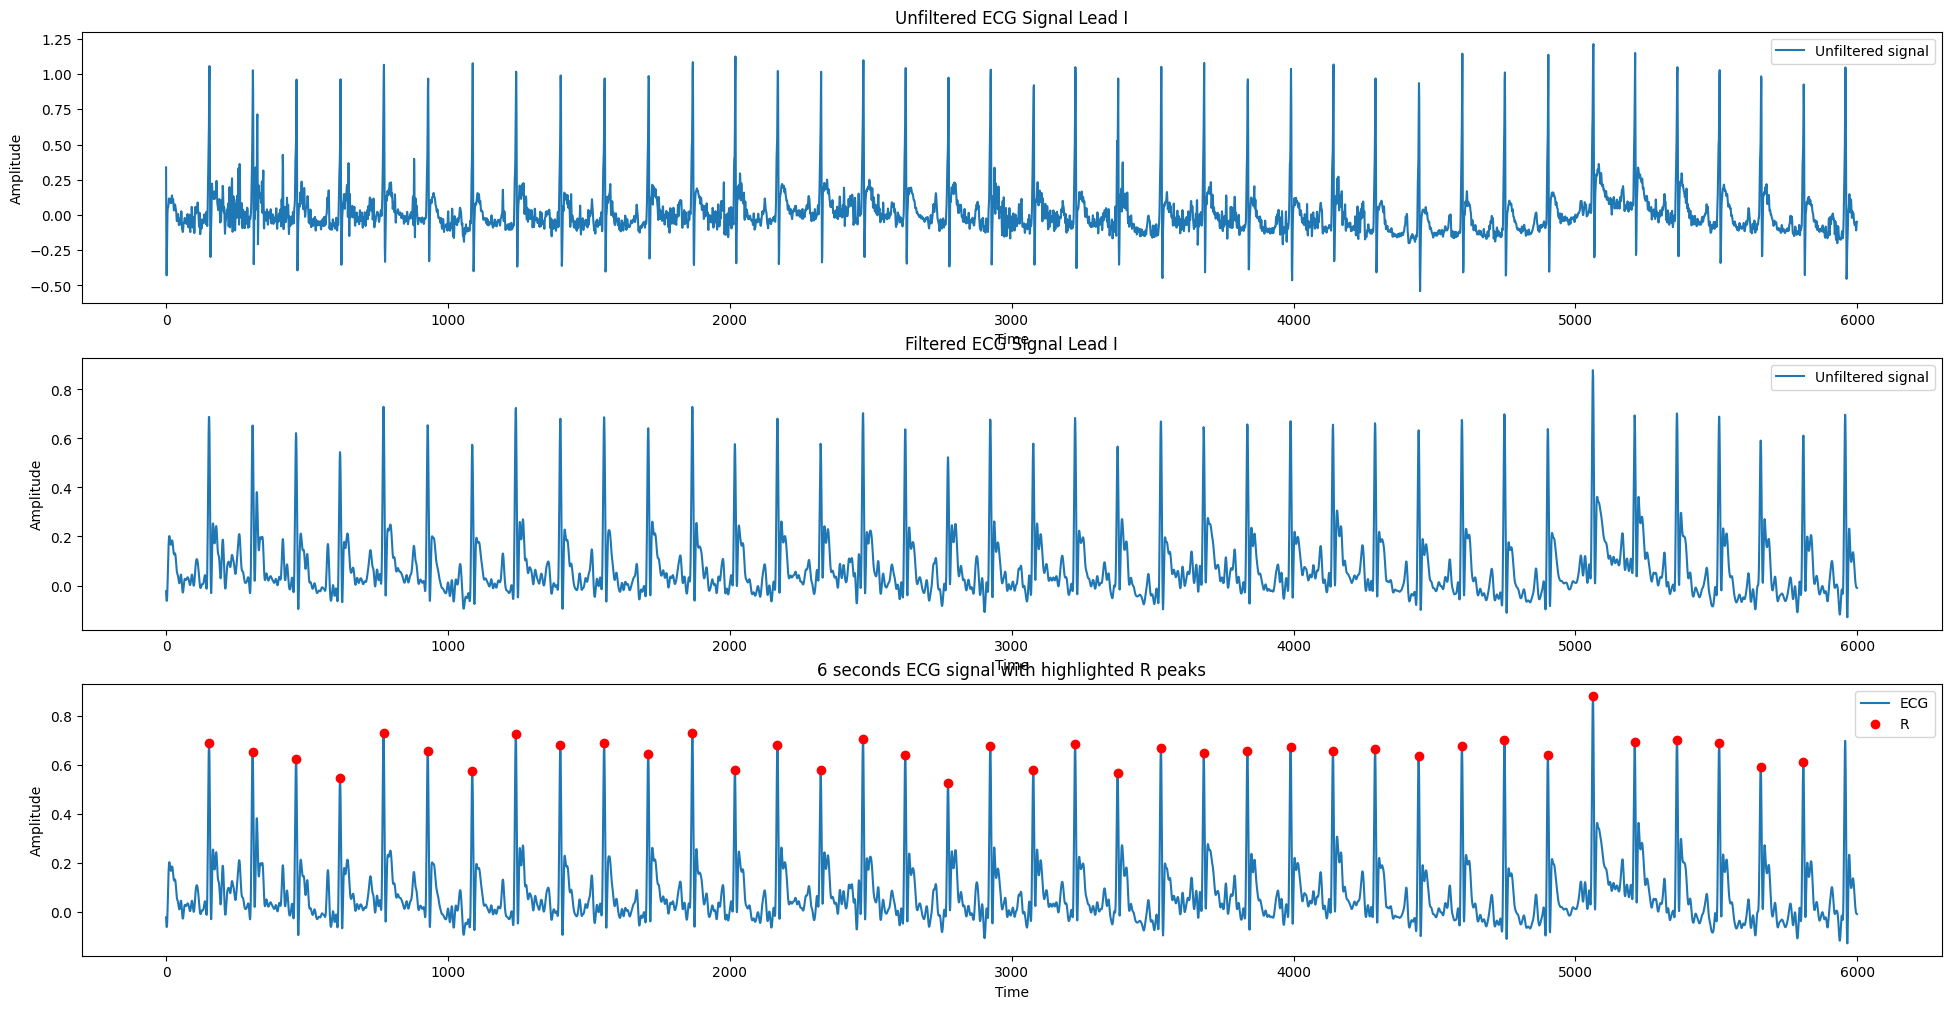

In [20]:
def selecionar_arquivo():
    Tk().withdraw()
    arquivo_selecionado = askopenfilename(
        title="Select Excel file",
        filetypes=[("Arquivo Excel", "*.xlsx *.xls")]
    )
    return arquivo_selecionado


caminho_do_arquivo = selecionar_arquivo()

if caminho_do_arquivo:
    workbook = load_workbook(filename=caminho_do_arquivo)
    sheet = workbook.active
    matriz_uma_coluna = [cell.value for cell in sheet['A']]
    signalraw = np.array(matriz_uma_coluna)


    filtered_signal, baseline = ecg_baseline_removal(signalraw, samplerate, window_length, overlap)
    filter_types = ['low', 'high', 'notch', 'band']
    final_filtered_signal = ecg_filter(filtered_signal, samplerate, filter_types, lowpass_frequency, highpass_frequency, notch_frequency, 'Butterworth')
    final_filtered_signal2 = final_filtered_signal  


    corrected_final_filtered_signal2, offset = isoline_correction(final_filtered_signal2)

    R_Cell_original, samplerate, signal = process_signal(corrected_final_filtered_signal2, samplerate)

    QPOS_vector, SPOS_vector, RPOS_vector = find_qrs_peaks(R_Cell_original, samplerate, signal)
        
    HR, HRV, HRV_mean, HRV_std, HRV_rms, Q, R, S, Remov = CalculateHRHRV(QPOS_vector, SPOS_vector, RPOS_vector, samplerate, corrected_final_filtered_signal2)

    rr_n = Remov[:-1]
    rr_n1 = Remov[1:]
    
    rr_variation = Remov - HRV_mean
    
    rr_n = rr_variation[:-1]
    rr_n1 = rr_variation[1:]
    
    
    plt.figure(figsize=(24, 12))
    plt.subplot(3, 1, 1)
    plt.plot(signalraw[:6000], label='Unfiltered signal')
    plt.title('Unfiltered ECG Signal Lead I')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(corrected_final_filtered_signal2[:6000], label='Unfiltered signal')
    plt.title('Filtered ECG Signal Lead I')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(signal[:6000], label='ECG')
    plt.plot(R[:38], [signal[i] for i in R[:38]], 'ro', label='R')  
    plt.title('6 seconds ECG signal with highlighted R peaks')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()


else:
    print("No files were selected.")